## Jagadish Tarla

## Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots later

np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.max_columns", None)

# Set a random seed for reproducibility
RANDOM_SEED = 40
np.random.seed(RANDOM_SEED)
print("Setup complete. Ready to load dataset.")

Setup complete. Ready to load dataset.


## Load and Inspect Dataset

In [2]:
DATA_PATH = "Obesity.csv"
try:
    obesity_df = pd.read_csv(DATA_PATH)
    print("Dataset loaded successfully with shape:", obesity_df.shape)
    display(obesity_df.head())
    print("\nAvailable columns:", obesity_df.columns.tolist())
except FileNotFoundError:
    print("File not found. Please place Obesity.csv in the notebook directory or update DATA_PATH.")

Dataset loaded successfully with shape: (2111, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II



Available columns: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']


## Standardization

In [3]:
def standardize_features(df, feature_list):
    """
    Standardize numeric features to mean 0, std 1.
    Returns:
        X_scaled: ndarray (n_samples, n_features)
        mean: ndarray of feature means
        std: ndarray of feature stds
    """
    data = df[feature_list].astype(float).values
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    std[std == 0] = 1.0
    X_scaled = (data - mean) / std
    return X_scaled, mean, std

# standardize Age, Height, Weight
selected_features = ["Age", "Height", "Weight"]
X_init, mu_init, std_init = standardize_features(obesity_df, selected_features)

print("Standardized shape:", X_init.shape)
print("Means after scaling (approx.):", X_init.mean(axis=0))
print("Stds after scaling (approx.):", X_init.std(axis=0))

Standardized shape: (2111, 3)
Means after scaling (approx.): [ 0. -0. -0.]
Stds after scaling (approx.): [1. 1. 1.]


# 1-a K-means implementation with (k=2)

In [4]:
def kmeans_basic(X, k, max_iters=300, tol=1e-4, seed=40):
    np.random.seed(seed)
    # Step 1: initialize centroids randomly from data points
    initial_idx = np.random.choice(X.shape[0], size=k, replace=False)
    centroids = X[initial_idx]

    for _ in range(max_iters):
        # Step 2: assign each point to the nearest centroid
        distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
        labels = np.argmin(distances, axis=1)

        # Step 3: recompute centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Step 4: check convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids

    return labels, centroids

# Run K-means with k=2 on standardized Age, Height, Weight
labels_k2, centroids_k2 = kmeans_basic(X_init, k=2)

print("Final centroids (standardized space):")
print(centroids_k2)

Final centroids (standardized space):
[[ 0.4445  0.4354  0.751 ]
 [-0.47   -0.4604 -0.7942]]


# 3D scatter for 1-a

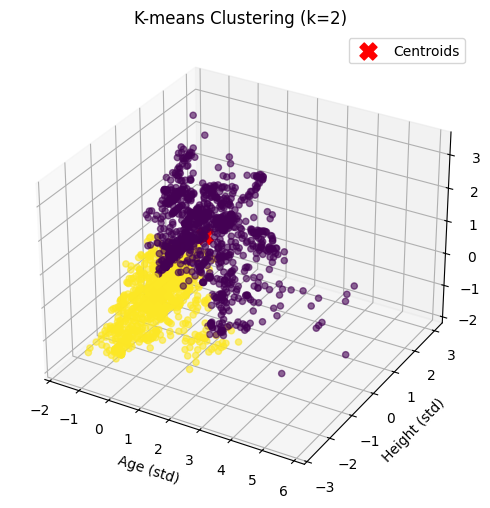

In [7]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X_init[:,0], X_init[:,1], X_init[:,2], 
           c=labels_k2, cmap="viridis", s=20, alpha=0.6)
ax.scatter(centroids_k2[:,0], centroids_k2[:,1], centroids_k2[:,2], 
           c="red", marker="X", s=150, label="Centroids")

ax.set_xlabel("Age (std)")
ax.set_ylabel("Height (std)")
ax.set_zlabel("Weight (std)")
ax.set_title("K-means Clustering (k=2)")
ax.legend()
plt.show()

# 1b – Sequential 3D Plots for k=2..10

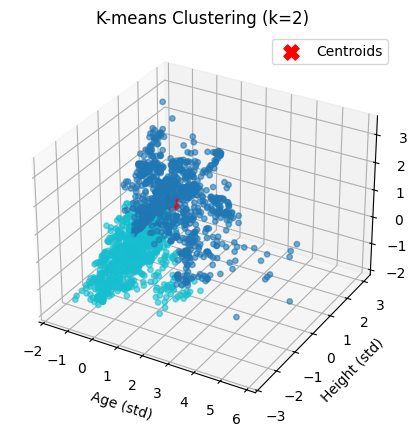

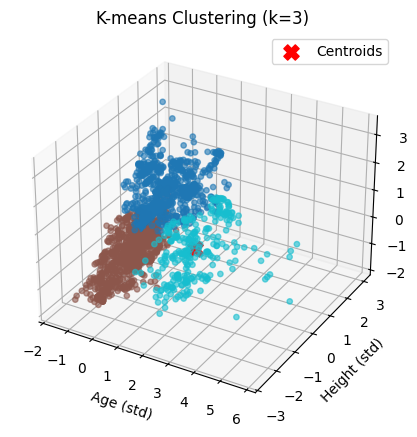

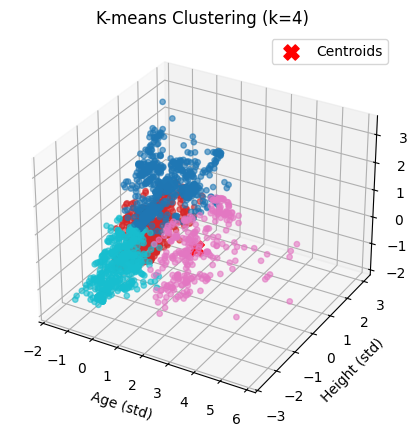

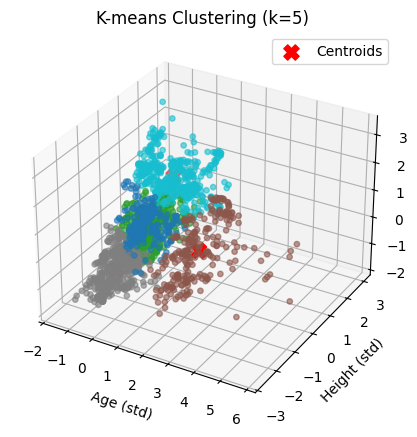

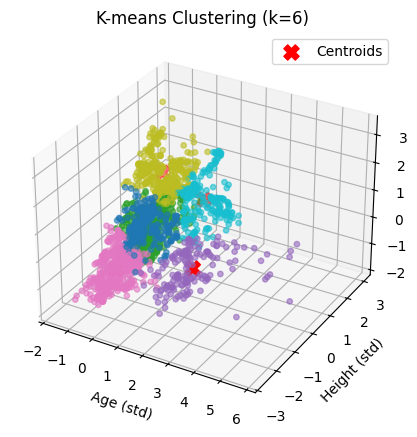

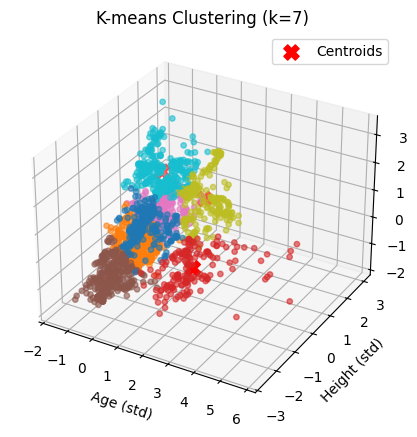

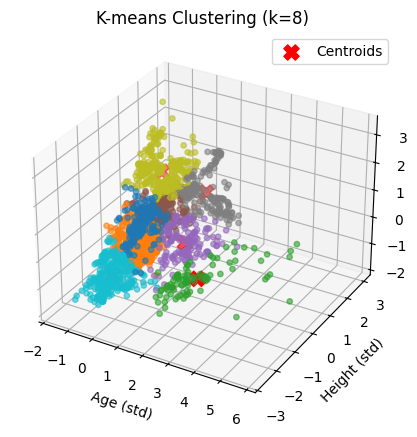

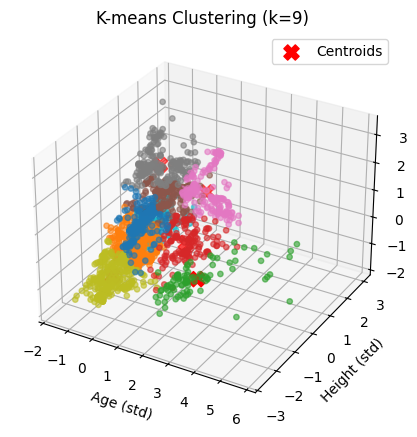

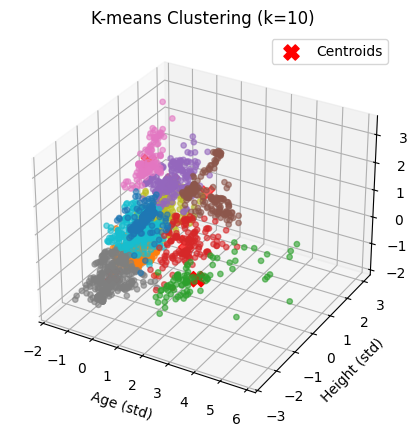

In [9]:
for k in range(2, 11):
    labels, centroids = kmeans_basic(X_init, k=k, seed=40)
    
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection="3d")
    
    ax.scatter(X_init[:,0], X_init[:,1], X_init[:,2], 
               c=labels, cmap="tab10", s=15, alpha=0.6)
    ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
               c="red", marker="X", s=120, label="Centroids")
    
    ax.set_xlabel("Age (std)")
    ax.set_ylabel("Height (std)")
    ax.set_zlabel("Weight (std)")
    ax.set_title(f"K-means Clustering (k={k})")
    ax.legend()
    plt.show()

## Dunn Index Implementation

In [8]:
def dunn_index(X, labels):
    """Compute Dunn Index = min inter-cluster distance / max intra-cluster diameter."""
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    # Precompute distances
    dist_matrix = np.linalg.norm(X[:, None] - X[None, :], axis=2)

    # Cluster diameters (max intra-cluster distance)
    diameters = []
    for c in unique_labels:
        members = np.where(labels == c)[0]
        if len(members) > 1:
            diam = dist_matrix[np.ix_(members, members)].max()
        else:
            diam = 0.0
        diameters.append(diam)
    max_diameter = max(diameters)

    # Inter-cluster distances (min between any two points in different clusters)
    inter_dists = []
    for i in range(len(unique_labels)):
        for j in range(i+1, len(unique_labels)):
            ci = np.where(labels == unique_labels[i])[0]
            cj = np.where(labels == unique_labels[j])[0]
            inter = dist_matrix[np.ix_(ci, cj)].min()
            inter_dists.append(inter)
    min_inter = min(inter_dists)

    return min_inter / max_diameter if max_diameter > 0 else 0.0

# 1-c Compute DI for k=2 to 10

,k,DunnIndex
0,2,0.005654
1,3,0.006641
2,4,0.008032
3,5,0.007731
4,6,0.006697
5,7,0.008089
6,8,0.008732
7,9,0.003254
8,10,0.008434


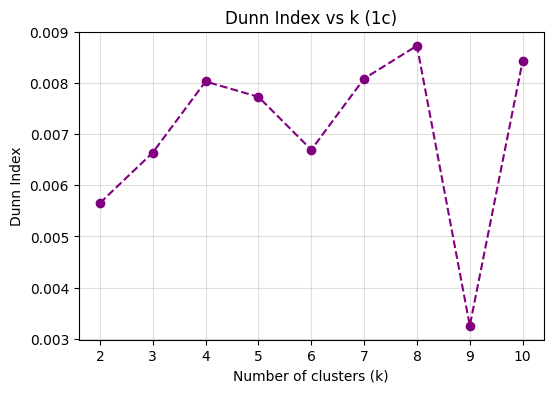

Best k by Dunn Index = 8 with DI = 0.0087


In [11]:
results = []
for k in range(2, 11):
    labels, centroids = kmeans_basic(X_init, k=k, seed=40)
    di = dunn_index(X_init, labels)
    results.append((k, di))

# Convert to DataFrame
import pandas as pd
di_df = pd.DataFrame(results, columns=["k", "DunnIndex"])
display(di_df)

# Plot DI vs k
plt.figure(figsize=(6,4))
plt.plot(di_df["k"], di_df["DunnIndex"], marker="o", linestyle="--", color="purple")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Dunn Index")
plt.title("Dunn Index vs k (1c)")
plt.grid(True, alpha=0.4)
plt.show()

# Best k according to DI
best_k_row = di_df.loc[di_df["DunnIndex"].idxmax()]
print(f"Best k by Dunn Index = {int(best_k_row.k)} with DI = {best_k_row.DunnIndex:.4f}")

# Problem 2a including CALC

In [15]:
# Encode CALC into numeric values
calc_map = {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3}
obesity_df["CALC_num"] = obesity_df["CALC"].map(calc_map)

# Define feature set
features_2a = ["Age", "Height", "Weight", "CALC_num"]

# Standardize
X_2a, _, _ = standardize_features(obesity_df, features_2a)

# Run K-means with best k=8
labels_2a, centroids_2a = kmeans_basic(X_2a, k=8, seed=40)

# Compute Dunn Index
di_2a = dunn_index(X_2a, labels_2a)

print("Problem 2a - Features:", features_2a)
print("Dunn Index with CALC added:", di_2a)

Problem 2a - Features: ['Age', 'Height', 'Weight', 'CALC_num']
Dunn Index with CALC added: 0.010835836237869004


# Problem 2b, including CALC + FAF

In [17]:
# Define feature set
features_2b = ["Age", "Height", "Weight", "CALC_num", "FAF"]

# Standardize
X_2b, _, _ = standardize_features(obesity_df, features_2b)

# Run K-means with best k=8
labels_2b, centroids_2b = kmeans_basic(X_2b, k=8, seed=40)

# Compute Dunn Index
di_2b = dunn_index(X_2b, labels_2b)

print("Problem 2b - Features:", features_2b)
print("Dunn Index with CALC + FAF added:", di_2b)

Problem 2b - Features: ['Age', 'Height', 'Weight', 'CALC_num', 'FAF']
Dunn Index with CALC + FAF added: 0.015150570690485327


# Problem 3a. Implement Fuzzy C-means and compare with K-means

## Fuzzy C-means Implementation

In [18]:
def fuzzy_c_means(X, k, m=2.0, max_iters=300, tol=1e-4, seed=40):
    """
    Fuzzy C-means clustering.
    X: data matrix (n x d)
    k: number of clusters
    m: fuzzifier (m > 1, typically 2)
    """
    np.random.seed(seed)
    n, d = X.shape

    # Initialize random membership matrix U (rows sum to 1)
    U = np.random.rand(n, k)
    U = U / U.sum(axis=1, keepdims=True)

    for _ in range(max_iters):
        U_old = U.copy()

        # Compute cluster centers
        U_m = U ** m
        centroids = (U_m.T @ X) / U_m.sum(axis=0)[:, None]

        # Update membership matrix
        dist = np.linalg.norm(X[:, None] - centroids[None, :], axis=2) + 1e-8
        power = 2 / (m - 1)
        U = 1.0 / (dist ** power)
        U = U / U.sum(axis=1, keepdims=True)

        # Check convergence
        if np.linalg.norm(U - U_old) < tol:
            break

    return U, centroids

def harden_memberships(U):
    """Convert fuzzy memberships to hard labels."""
    return np.argmax(U, axis=1)

## Run Fuzzy C means with best feature set

In [20]:
features_3a = ["Age", "Height", "Weight", "CALC_num", "FAF"]
X_3a, _, _ = standardize_features(obesity_df, features_3a)

# Run Fuzzy C-Means
U_fcm, centroids_fcm = fuzzy_c_means(X_3a, k=8, m=2.0, seed=40)
labels_fcm_hard = harden_memberships(U_fcm)

print("Fuzzy C-means centroids (standardized space):")
print(centroids_fcm)

# For comparison will get K-means centroids
labels_km, centroids_km = kmeans_basic(X_3a, k=8, seed=40)
print("\nK-means centroids (standardized space):")
print(centroids_km)

Fuzzy C-means centroids (standardized space):
[[-0.0818  0.0432 -0.3158  0.3342 -0.1985]
 [ 0.6661  0.9576  0.8807  0.4304 -0.0727]
 [-0.3495  0.2308 -0.4865  0.2691  0.7733]
 [-0.3681  0.2565 -0.5601 -1.1198  1.0261]
 [-0.2408  0.6837  1.3645  0.4681  0.4768]
 [-0.2731 -0.5644 -0.4183 -1.216  -0.4658]
 [-0.4486 -0.8663 -0.8487  0.3982 -0.1671]
 [ 0.282  -0.6528  0.7108  0.4794 -1.0508]]

K-means centroids (standardized space):
[[-0.4339 -0.6417 -0.4839 -1.4192 -0.5379]
 [-0.5793  0.4829 -0.5828  0.7131  0.9463]
 [ 2.2921 -0.795  -0.3404 -0.4307 -0.3873]
 [ 0.1306 -0.2191  0.4281  0.6089 -1.0363]
 [-0.3263  0.4021 -0.3355 -1.4192  1.3002]
 [ 1.3622  1.0785  0.849   0.6924  0.1305]
 [-0.3134  0.9057  1.4665  0.5148  0.3528]
 [-0.6494 -1.0346 -1.136   0.5856 -0.3131]]


# Problem 3b Harden FCM and Compare DI

In [21]:
# Harden FCM memberships
labels_fcm_hard = harden_memberships(U_fcm)

# Compute DI for both
di_kmeans = dunn_index(X_3a, labels_km)
di_fcm = dunn_index(X_3a, labels_fcm_hard)

print("Dunn Index - K-means:", di_kmeans)
print("Dunn Index - FCM (hardened):", di_fcm)

if di_fcm > di_kmeans:
    print("=> Fuzzy C-means produced better clusters by DI.")
else:
    print("=> K-means produced better clusters by DI.")

Dunn Index - K-means: 0.015150570690485327
Dunn Index - FCM (hardened): 0.0026749777432147435
=> K-means produced better clusters by DI.


# Problem 3c FCM with CH2O added

In [26]:
# Extended feature set
features_3c = ["Age", "Height", "Weight", "CALC_num", "FAF", "CH2O"]

# Standardize
X_3c, _, _ = standardize_features(obesity_df, features_3c)

# Run Fuzzy C-means with k=8
U_fcm_3c, centroids_fcm_3c = fuzzy_c_means(X_3c, k=8, m=2.0, seed=40)
labels_fcm_3c = harden_memberships(U_fcm_3c)

# Compute Dunn Index
di_3c = dunn_index(X_3c, labels_fcm_3c)

print("Problem 3c - Features:", features_3c)
print("Dunn Index(Fuzzy C Means) with CH2O added:", di_3c)

Problem 3c - Features: ['Age', 'Height', 'Weight', 'CALC_num', 'FAF', 'CH2O']
Dunn Index(Fuzzy C Means) with CH2O added: 0.002936196328112465


In [27]:
# Feature set from 3c
features_3c = ["Age", "Height", "Weight", "CALC_num", "FAF", "CH2O"]

# Standardize
X_3c, _, _ = standardize_features(obesity_df, features_3c)

# Run K-means with k=8
labels_km_3c, centroids_km_3c = kmeans_basic(X_3c, k=8, seed=40)

# Compute Dunn Index
di_km_3c = dunn_index(X_3c, labels_km_3c)

print("K-means on 6-feature set:", features_3c)
print("Dunn Index (K-means, 3c):", di_km_3c)

K-means on 6-feature set: ['Age', 'Height', 'Weight', 'CALC_num', 'FAF', 'CH2O']
Dunn Index (K-means, 3c): 0.010363191246913107
